# 線形回帰

以下のようなデータセットについて考える。
$$
D = \{(X_i, y_i)\}, \ \ \ {\rm for}\ \  i = 1, \cdots, N
$$

これに対して、線形回帰を行う。線形回帰は次のような関数で表すことが出来る。

$$
y = wX +b + \epsilon
$$

ここで$w, b$は学習可能なパラメータであり、$\epsilon$は観測時のノイズを表す項である。

**モジュールのインポート**

In [1]:
import os
from functools import partial
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist

pyro.enable_validation(True)
pyro.set_rng_seed(1)
pyro.enable_validation(True)

%matplotlib inline
plt.style.use('default')

**データセット**

国における一人あたりのGDPと地形に相関があるかどうかを調べる

- cont_africa: アフリカにあるかどうか
- rugged: 地形の悪さを表す指標
- rgdppc_2000: 2000年の一人あたりの実質GDP

In [5]:
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

In [3]:
df.head()

,cont_africa,rugged,rgdppc_2000
2,1,0.858,7.492609
4,0,3.427,8.216929
7,0,0.769,9.933263
8,0,0.775,9.407032
9,0,2.688,7.792343


In [6]:
df["cont_africa_x_rugged"] = df["cont_africa"] * df["rugged"]
data = torch.tensor(df[["cont_africa", "rugged", "cont_africa_x_rugged", "rgdppc_2000"]].values,
                        dtype=torch.float)
x_data, y_data = data[:, :-1], data[:, -1]

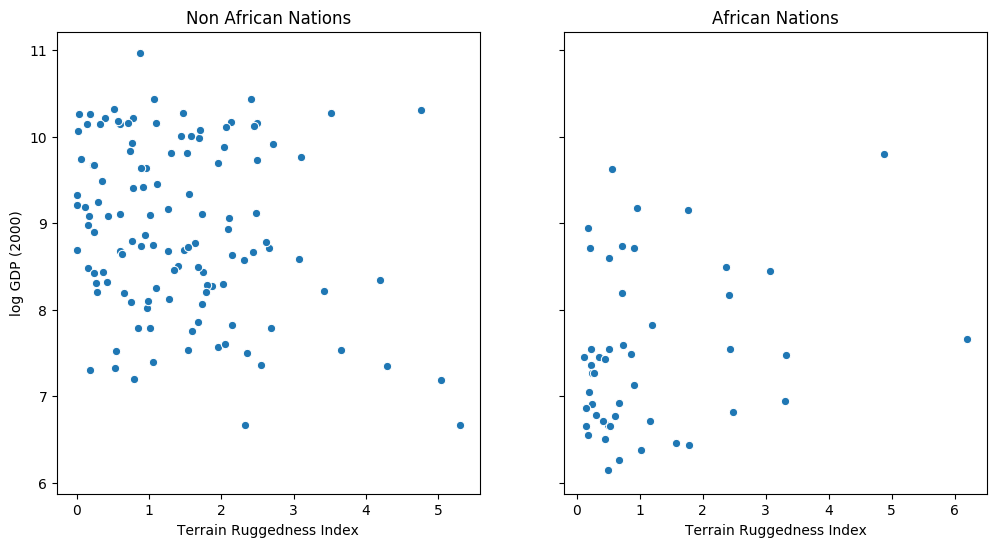

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = df[df["cont_africa"] == 1]
non_african_nations = df[df["cont_africa"] == 0]
sns.scatterplot(non_african_nations["rugged"],
            non_african_nations["rgdppc_2000"],
            ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
sns.scatterplot(african_nations["rugged"],
                african_nations["rgdppc_2000"],
                ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

## Pytorchによる点推定を用いた線形回帰

In [16]:
# Pyroチュートリアルだと、PyroModule[nn.Linear]を使っていたが、pytorchだけを使ってみる
from torch import nn

class LinearRegression(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.layer = torch.nn.Linear(in_features, out_features, bias=True)

    def forward(self, x):
        y = self.layer(x)
        return y

In [17]:
# モデル
linear_reg_model = LinearRegression(3, 1)

# 損失関数と最適化手法の定義
loss_fn =nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(linear_reg_model.parameters(), lr=0.05)
num_iterations = 1500

def train():
    y_pred = linear_reg_model(x_data).squeeze(-1)
    loss = loss_fn(y_pred, y_data)
    optim.zero_grad()
    loss.backward()
    optim.step()
    return loss

for j in range(num_iterations):
    loss = train()
    if (j + 1) % 50 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss.item()))


print("Learned parameters:")
for name, param in linear_reg_model.named_parameters():
    print(name, param.data.numpy())

[iteration 0050] loss: 3374.1870
[iteration 0100] loss: 1733.4231
[iteration 0150] loss: 1184.5186
[iteration 0200] loss: 883.6413
[iteration 0250] loss: 671.7889
[iteration 0300] loss: 511.2416
[iteration 0350] loss: 391.3449
[iteration 0400] loss: 305.3193
[iteration 0450] loss: 246.1695
[iteration 0500] loss: 207.1395
[iteration 0550] loss: 182.3892
[iteration 0600] loss: 167.2910
[iteration 0650] loss: 158.4255
[iteration 0700] loss: 153.4126
[iteration 0750] loss: 150.6824
[iteration 0800] loss: 149.2503
[iteration 0850] loss: 148.5268
[iteration 0900] loss: 148.1748
[iteration 0950] loss: 148.0100
[iteration 1000] loss: 147.9357
[iteration 1050] loss: 147.9035
[iteration 1100] loss: 147.8901
[iteration 1150] loss: 147.8847
[iteration 1200] loss: 147.8827
[iteration 1250] loss: 147.8819
[iteration 1300] loss: 147.8817
[iteration 1350] loss: 147.8816
[iteration 1400] loss: 147.8815
[iteration 1450] loss: 147.8815
[iteration 1500] loss: 147.8815
Learned parameters:
layer.weight [[-1

プロット

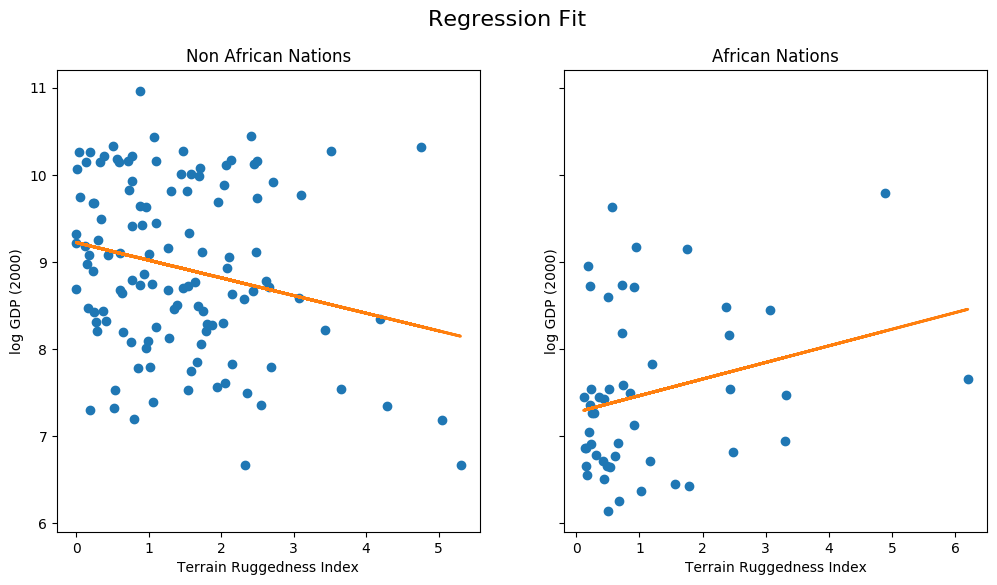

In [18]:
fit = df.copy()
fit["mean"] = linear_reg_model(x_data).detach().cpu().numpy()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = fit[fit["cont_africa"] == 1]
non_african_nations = fit[fit["cont_africa"] == 0]
fig.suptitle("Regression Fit", fontsize=16)
ax[0].plot(non_african_nations["rugged"], non_african_nations["rgdppc_2000"], "o")
ax[0].plot(non_african_nations["rugged"], non_african_nations["mean"], linewidth=2)
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
ax[1].plot(african_nations["rugged"], african_nations["rgdppc_2000"], "o")
ax[1].plot(african_nations["rugged"], african_nations["mean"], linewidth=2)
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

## Pyroの確率的変分推論(SVI)によるベイジアン線形回帰

### モデル

$$
y \sim {\mathcal N}(wX +b, \sigma) \\
\sigma \sim {\rm Uni}(0, 10)
$$

事前分布
$$
w_0 \sim {\mathcal N}(0, 1) \\
b_0 \sim {\mathcal N}(0, 10)
$$

In [19]:
from pyro.nn import PyroModule
from pyro.nn import PyroSample

class BayesianRegression(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        # NOTE: to_event(2)はどこから来たのか
        self.linear.weight = PyroSample(dist.Normal(0., 1.).expand([out_features, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 10.).expand([out_features]).to_event(1))

    def forward(self, x, y=None):
        # NOTE: sigmaが一様分布なのは何故？正規分布では何がいけないのか？
        # ANS: 普通ならガンマ分布、0未満だと困る
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

### AutoGuide

AutoGuideでは、モデル内の観測されていないデータのパラメータに対角共分散を持つ多次元ガウス分布としてモデル化するAutoDiagonalNormalガイドを利用する。つまりD個の独立した一次元ガウス分布であるため、潜在変数に相関は無い強い仮定をおいた近似事後分布。

ここでは$w \in {\mathbb R}, b \in {\mathbb R}, X \in {\mathbb R}^3$で対角共分散は$\Sigma \in {\mathbb R}^{5\times 5}$

In [20]:
from pyro.infer.autoguide import AutoDiagonalNormal

model = BayesianRegression(3, 1)
guide = AutoDiagonalNormal(model)

### ELBOを用いた最適化

点推定での線形回帰では、MSE損失関数を用いて最適化を行っていたが、ベイジアン線形回帰では確率的変分推論を用いてELBO（ELBOを用いた最適化）を最大化させることで学習を行う。


In [21]:
from pyro.infer import SVI, Trace_ELBO


adam = pyro.optim.Adam({"lr": 0.03})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

`torch.optim.Adam`の代わりに`pyro.optim.Adam`を使っているところに注意！Pyro’s parameter storeを使って学習するためには`pyro.optim.Adam`を使う必要がある。

In [22]:
pyro.clear_param_store()
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(x_data, y_data)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))

[iteration 0001] loss: 5.6426
[iteration 0101] loss: 3.5057
[iteration 0201] loss: 3.2892
[iteration 0301] loss: 2.9100
[iteration 0401] loss: 2.5382
[iteration 0501] loss: 1.7509
[iteration 0601] loss: 1.4701
[iteration 0701] loss: 1.4600
[iteration 0801] loss: 1.4597
[iteration 0901] loss: 1.4673
[iteration 1001] loss: 1.4723
[iteration 1101] loss: 1.4684
[iteration 1201] loss: 1.4592
[iteration 1301] loss: 1.4983
[iteration 1401] loss: 1.4656


最適化された近似事後分布のパラメータを見る

In [24]:
guide.requires_grad_(False)

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

AutoDiagonalNormal.loc Parameter containing:
tensor([-2.2577, -1.7781, -0.1586,  0.3826,  9.1981])
AutoDiagonalNormal.scale tensor([0.0605, 0.1354, 0.0351, 0.0783, 0.0734])


より詳細に近似事後分布を見ることが出来る。

Note: latent samplesって何？

In [25]:
guide.quantiles([0.25, 0.5, 0.75])

{'sigma': [tensor(0.9124), tensor(0.9468), tensor(0.9824)],
 'linear.weight': [tensor([[-1.8694, -0.1822,  0.3298]]),
  tensor([[-1.7781, -0.1586,  0.3826]]),
  tensor([[-1.6867, -0.1349,  0.4354]])],
 'linear.bias': [tensor([9.1486]), tensor([9.1981]), tensor([9.2476])]}

### モデル評価

`Predictive`クラスを用いて、ベイズ線形回帰からデータの生成を行い、予測分布を確認する。

In [26]:
from pyro.infer import Predictive


def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats


predictive = Predictive(model, guide=guide, num_samples=800,
                        return_sites=("linear.weight", "obs", "_RETURN"))
# NOTE: ここらへんが意味わからない観測しているXを受け取ってサンプルを返すとはどういうことなのか
# p(x)を返しているのだと思うけど…
# ANS: 800つの予測分布をサンプリング
samples = predictive(x_data)
pred_summary = summary(samples)

In [28]:
mu = pred_summary["_RETURN"]
y = pred_summary["obs"]
predictions = pd.DataFrame({
    "cont_africa": x_data[:, 0],
    "rugged": x_data[:, 1],
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_gdp": y_data,
})

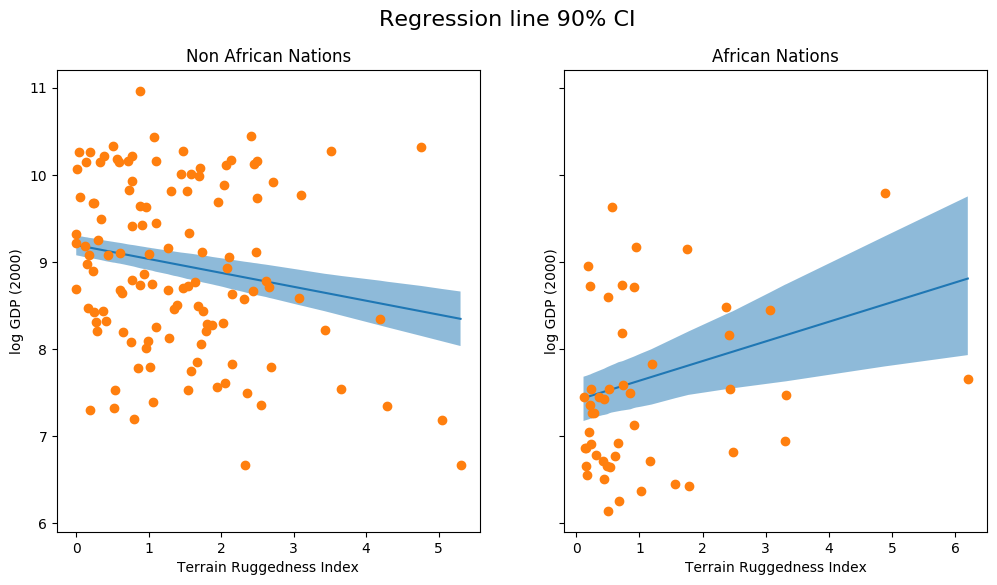

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = predictions[predictions["cont_africa"] == 1]
non_african_nations = predictions[predictions["cont_africa"] == 0]
african_nations = african_nations.sort_values(by=["rugged"])
non_african_nations = non_african_nations.sort_values(by=["rugged"])
fig.suptitle("Regression line 90% CI", fontsize=16)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["mu_mean"])
ax[0].fill_between(non_african_nations["rugged"],
                   non_african_nations["mu_perc_5"],
                   non_african_nations["mu_perc_95"],
                   alpha=0.5)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["true_gdp"],
           "o")
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
idx = np.argsort(african_nations["rugged"])
ax[1].plot(african_nations["rugged"],
           african_nations["mu_mean"])
ax[1].fill_between(african_nations["rugged"],
                   african_nations["mu_perc_5"],
                   african_nations["mu_perc_95"],
                   alpha=0.5)
ax[1].plot(african_nations["rugged"],
           african_nations["true_gdp"],
           "o")
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

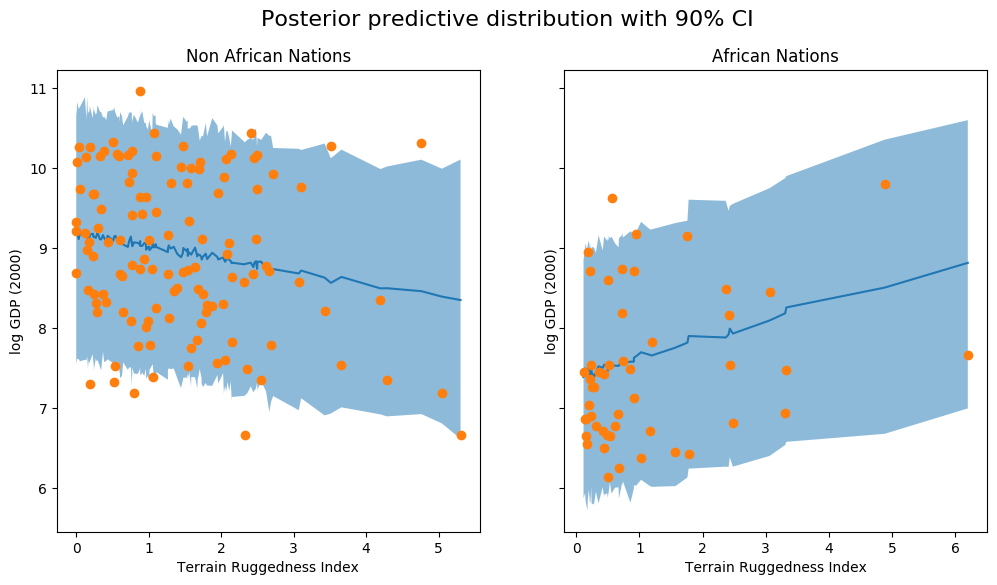

In [30]:
# \sigmaも考慮に入れたプロット
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle("Posterior predictive distribution with 90% CI", fontsize=16)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["y_mean"])
ax[0].fill_between(non_african_nations["rugged"],
                   non_african_nations["y_perc_5"],
                   non_african_nations["y_perc_95"],
                   alpha=0.5)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["true_gdp"],
           "o")
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
idx = np.argsort(african_nations["rugged"])

ax[1].plot(african_nations["rugged"],
           african_nations["y_mean"])
ax[1].fill_between(african_nations["rugged"],
                   african_nations["y_perc_5"],
                   african_nations["y_perc_95"],
                   alpha=0.5)
ax[1].plot(african_nations["rugged"],
           african_nations["true_gdp"],
           "o")
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

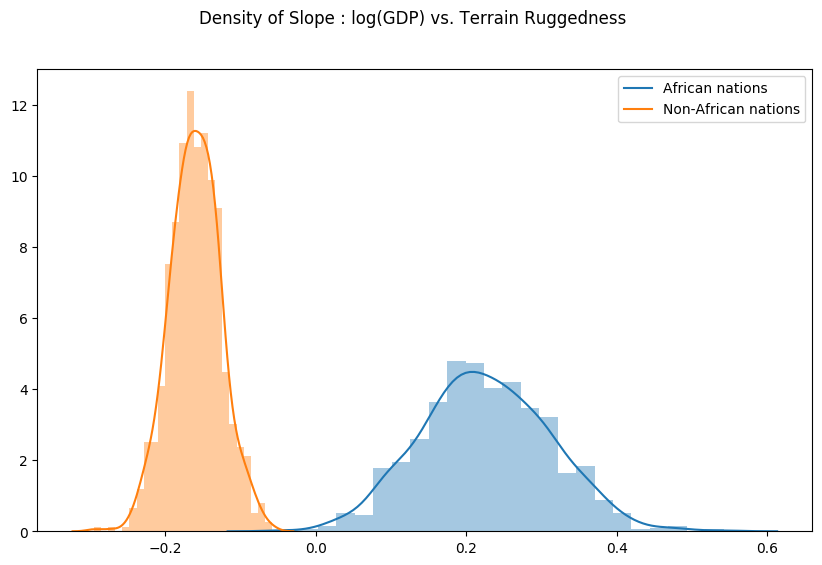

In [31]:
# NOTE: 傾き
weight = samples["linear.weight"]
weight = weight.reshape(weight.shape[0], 3)
gamma_within_africa = weight[:, 1] + weight[:, 2]
gamma_outside_africa = weight[:, 1]
fig = plt.figure(figsize=(10, 6))
sns.distplot(gamma_within_africa, kde_kws={"label": "African nations"},)
sns.distplot(gamma_outside_africa, kde_kws={"label": "Non-African nations"})
fig.suptitle("Density of Slope : log(GDP) vs. Terrain Ruggedness");